#### **Data Preparation**


In [31]:
import pandas as pd
import numpy as np

column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'sex',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income'
]

df = pd.read_csv('adult.data', header=None, names=column_names)

df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


**Data Quality Validation**

Verify for missing values in numerical columns

In [32]:
# Separate numerical and categorical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Check for missing values in numerical columns
numerical_missing = df[numerical_columns].isnull().sum()
numerical_percentage = (numerical_missing / len(df)) * 100

# Create a summary for numerical columns
numerical_summary = pd.DataFrame({
    'Missing Values': numerical_missing,
    'Percentage': numerical_percentage
})

print("Missing Values Summary for Numerical Columns:")
print(numerical_summary)

Missing Values Summary for Numerical Columns:
                Missing Values  Percentage
age                          0         0.0
fnlwgt                       0         0.0
education_num                0         0.0
capital_gain                 0         0.0
capital_loss                 0         0.0
hours_per_week               0         0.0



Verify for missing values in categorical columns

In [33]:
# Get categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Check unique values for each categorical column
total_rows = len(df)
for col in categorical_columns:
    missing_count = df[col].str.strip().isin(['?', '', 'NA', 'nan', 'None', ' ']).sum()
    missing_pct = round(missing_count / len(df) * 100, 2)
    if missing_count > 0:
        print(f"\n{col}:")
        print("Number of missing values:", missing_count)
        print("Percentage of missing values:", missing_pct,"%")
        print("-" * 50)


workclass:
Number of missing values: 1836
Percentage of missing values: 5.64 %
--------------------------------------------------

occupation:
Number of missing values: 1843
Percentage of missing values: 5.66 %
--------------------------------------------------

native_country:
Number of missing values: 583
Percentage of missing values: 1.79 %
--------------------------------------------------


Impute the dataframe by filling the null values with value 'Unknown' for the categorical columns with missing values.

In [34]:
# Create a copy of the dataframe
df_processed = df.copy()

# Replace '?' with np.nan
df_processed = df_processed.replace('?', np.nan)

# Fill missing values with 'Unknown' for categorical columns
categorical_columns = df_processed.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df_processed[col] = df_processed[col].fillna('Unknown')

# Check the number of missing values in each column after filling missing values
missing_values = df_processed.isnull().sum()
print("\nMissing values after filling with 'Unknown':")
print(missing_values[missing_values > 0])


Missing values after filling with 'Unknown':
Series([], dtype: int64)


**Encode the categorical variables**

In [35]:
from sklearn.preprocessing import LabelEncoder
# Encode categorical variables
le = LabelEncoder() # Initialize LabelEncoder
for col in categorical_columns:
    df_processed[col] = le.fit_transform(df_processed[col])

# Check the first five rows of the processed dataframe
df_processed.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


**Feature Selection using Ridge**

In [36]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data into features (X) and target (y)
X = df_processed.drop("income", axis=1)
y = df_processed["income"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Feature Selection using Lasso (L1 penalty)
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
lasso.fit(X_train_scaled, y_train)

# Use SelectFromModel to select features with non-zero coefficients
selector_lasso = SelectFromModel(lasso, prefit=True)
X_train_lasso = selector_lasso.transform(X_train_scaled)
X_test_lasso = selector_lasso.transform(X_test_scaled)

selected_features_lasso = X_train.columns[selector_lasso.get_support()]
print("Selected features using Lasso (L1):")
print(selected_features_lasso)

### Feature Selection using Ridge (L2 penalty)
ridge = LogisticRegression(penalty='l2', solver='liblinear', C=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train)

# Extract the absolute coefficient values from the ridge model
ridge_coefs = np.abs(ridge.coef_[0])

# Set a threshold to filter features. Here, we choose 0.1.
threshold = 0.1
ridge_selected_mask = ridge_coefs > threshold
selected_features_ridge = X_train.columns[ridge_selected_mask]

print("\nSelected features using Ridge (L2) with coefficient threshold {:.2f}:".format(threshold))
print(selected_features_ridge)

Selected features using Lasso (L1):
Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country'],
      dtype='object')

Selected features using Ridge (L2) with coefficient threshold 0.10:
Index(['age', 'education_num', 'marital_status', 'relationship', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week'],
      dtype='object')


Lasso regression didn't exclude any variables. 

Feature selection with Ridge model excluded the below features.

- workclass
- fnlwgt
- education
- occupation
- race
- native_country

Dropping the variables excluded by ridge

In [37]:
# Drop the specified columns
df_clean = df_processed.drop(['workclass','fnlwgt', 'education', 'occupation', 'race', 'native_country'], axis=1)

# Add a new feature "Has_capital" (binary feature for whether person has any capital gains or losses)
df_clean['has_capital'] = ((df_clean['capital_gain'] > 0) | (df_clean['capital_loss'] > 0)).astype(int)

In [38]:
# Show the first few rows of the dataframe
df_clean.head()

,age,education_num,marital_status,relationship,sex,capital_gain,capital_loss,hours_per_week,income,has_capital
0,39,13,4,1,1,2174,0,40,0,1
1,50,13,2,0,1,0,0,13,0,0
2,38,9,0,1,1,0,0,40,0,0
3,53,7,2,0,1,0,0,40,0,0
4,28,13,2,5,0,0,0,40,0,0


**Description of each attribute**

1. **Age**: Age of person in years (continuous).
2. **education_num**: Numerical encoding of education level (continuous).
3. **marital_status**: Numerical encoding of marital status (Married, Divorced, Never-married, etc).
4. **relationship**: Numerical encoding of relationship status in family (Wife, Husband, Not-in-family, etc).
5. **sex**: Numerical encoding of gender (Male/Female).
6. **capital_gain**: Capital gains recorded (continuous).
7. **capital_loss**: Capital losses recorded (continuous).
8. **hours_per_week**: Hours worked per week (continuous).
9. **income**: Binary feature to indicate whether a person's income is <=50K or >50K.
10. **has_capital**: Binary feature to indicate whether person has any capital gains or losses.

#### **Modelling and Evaluation** 

**Classification Tasks**  
1. We will create 3 classification models to predict if a person has capital costs. 

**Choosing Evaluation Metrics for Classification Task1**  

Predicting if a Person has Capital Costs (Capital Gain or Capital Loss) can be useful in multiple business use cases like the below: 



1. Identifying Clients for Personalized Investment advice and Wealth Management
2. Predicting capital cost activity can help in designing tax optimization strategies
3. Identifying clients who might benefit from advanced tax planning services.
4. Banks can design products like specialized trading accounts or investment advisory services for individuals with active capital market participation.
5. Insurance Products - Companies might offer financial insurance products or hedging strategies tailored for individuals experiencing significant capital gains or losses.


In most of these business cases, Identifying the persons with capital costs correctly is important because this will help in targeted marketing of the products tailored for customers with high capital costs and in turn lead to more revenue for businesses. False positives will increase the expenditure because of the businesses will spend more resources selling their products to wrong customer base. 

Considering the above and the imbalanced dataset that we have (most of the customers in the dataset doesn't have any captial costs), we determine that below metrcis will be the appropriate ones to analyze the results of the models created and choose the best one depends on the business case. 

**Accuracy:**
Measures the proportion of all predictions (persons with and without capital cost) that are correct. This will help us understand overall corrrectness of predictions.  

**Precision:**
Measures the proportion of predicted positives (persons flagged as having capital costs) that are actually correct. This is valuable  because false positives will increase the expenditure because of businesses will spend more resources selling their products to wrong customer base based on false predictions.

**Recall (Sensitivity)**
Indicates the proportion of actual positives (persons who truly have capital costs) that are correctly identified. This is especially important because missing a true case (false negative) is critical because it might lead to revenue loss because businesses will miss reaching to out potential customers.

**ROC AUC:**
Assesses the model’s ability to distinguish between the classes at various thresholds by plotting the true positive rate against the false positive rate. It provides an overall sense of discrimination independent of any specific threshold, which is useful for imbalanced data.




**Choosing the method to divide data into training and testing splits for classifcation task1**

We choose stratified k-fold cross validation to divide data into training and testing splits

**How it works:** It splits the data into k “folds.” For each iteration, use one fold as the test set and the remaining k–1 folds for training, then rotate.

**Reason for choosing this method**
- It makes efficient use of data, since every observation ends up in a test fold exactly once.
- It maintains the same proportion of classes in each fold as in the full dataset. This is important because our dataset is imbalanced dataset. 

**[20 points]** Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!

**Classification Task 1 - Creating 3 different classifcation models to predict if a person has capital costs**

In [55]:
# Sklearn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    precision_score, recall_score, roc_auc_score, accuracy_score,
    ConfusionMatrixDisplay, RocCurveDisplay
)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ================================================
# 1. DATA PREPARATION
# ================================================

X = df_clean.drop(columns=['has_capital','capital_gain','capital_loss']) # Drop the target and capital columns used to create 'has_capital' to prevent leakage
y = df_clean['has_capital']

# Split into train (80%) and test (20%), stratified by target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ================================================
# 2. SET UP STRATIFIED K-FOLD
# ================================================
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# ================================================
# 3. DEFINE MODEL PARAMETERS
# ================================================

# Logistic Regression parameters
logreg_param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.01, 0.1, 1, 10],
    "solver": ["liblinear"],
    "max_iter": [5000],
    "random_state": [42]
}

# Random Forest parameters
rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10],
    "class_weight": ["balanced"],
    "random_state": [42]
}

# Naive Bayes parameters
gnb_param_grid = {
    "var_smoothing": [1e-9, 1e-8, 1e-7]
}

# ================================================
# 4. DEFINE A HELPER FUNCTION FOR GRID SEARCH
# ================================================
def perform_grid_search(model_class, param_grid, X_train, y_train, cv):
    grid = GridSearchCV(
        model_class(), param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=0
    )
    grid.fit(X_train, y_train)
    return grid.best_estimator_, grid.best_score_

# ================================================
# 5. RUN GRID SEARCH FOR EACH MODEL
# ================================================
best_logreg, best_score_logreg = perform_grid_search(
    LogisticRegression, logreg_param_grid, X_train_scaled, y_train, cv
)
best_rf, best_score_rf = perform_grid_search(
    RandomForestClassifier, rf_param_grid, X_train_scaled, y_train, cv
)
best_gnb, best_score_gnb = perform_grid_search(
    GaussianNB, gnb_param_grid, X_train_scaled, y_train, cv
)

print("Best Logistic Regression (CV ROC AUC):", best_score_logreg)
print("Best Random Forest (CV ROC AUC):      ", best_score_rf)
print("Best Naive Bayes (CV ROC AUC):        ", best_score_gnb)

# ================================================
# 6. EVALUATE FINAL MODELS ON TEST SET
# ================================================
models = {
    "Logistic Regression": best_logreg,
    "Random Forest": best_rf,
    "Naive Bayes": best_gnb
}

results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "ROC AUC": []
}

for name, model in models.items():
    # Predict on the test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results["Model"].append(name)
    results["Accuracy"].append(accuracy)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["ROC AUC"].append(roc_auc)

    print(f"\n{name} Performance on Test Set:")
    print(f"Accuracy:   {accuracy:.4f}")
    print(f"Precision:  {precision:.4f}")
    print(f"Recall:     {recall:.4f}")
    print(f"ROC AUC:    {roc_auc:.4f}")


Best Logistic Regression (CV ROC AUC): 0.7341951140269417
Best Random Forest (CV ROC AUC):       0.7275767605736075
Best Naive Bayes (CV ROC AUC):         0.7257834685178965

Logistic Regression Performance on Test Set:
Accuracy:   0.8704
Precision:  0.7500
Recall:     0.0035
ROC AUC:    0.7139

Random Forest Performance on Test Set:
Accuracy:   0.7608
Precision:  0.2840
Recall:     0.5532
ROC AUC:    0.7129

Naive Bayes Performance on Test Set:
Accuracy:   0.7864
Precision:  0.2925
Recall:     0.4539
ROC AUC:    0.7128


**Analysis of results using visualizations**

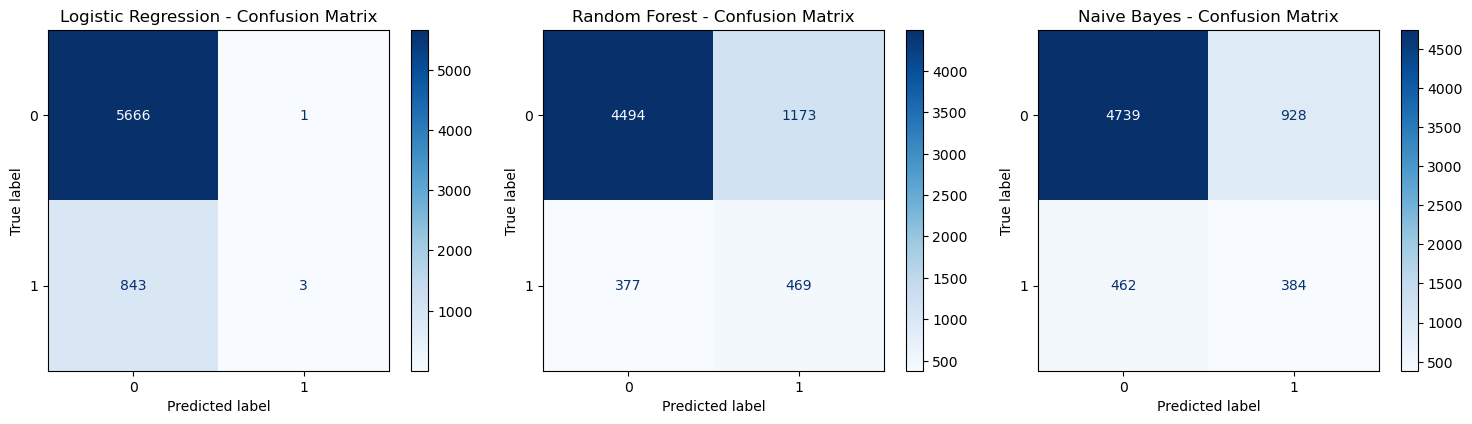

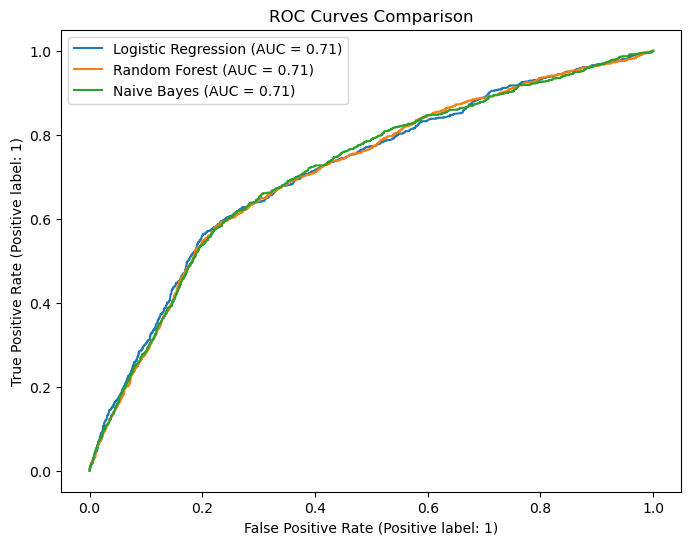

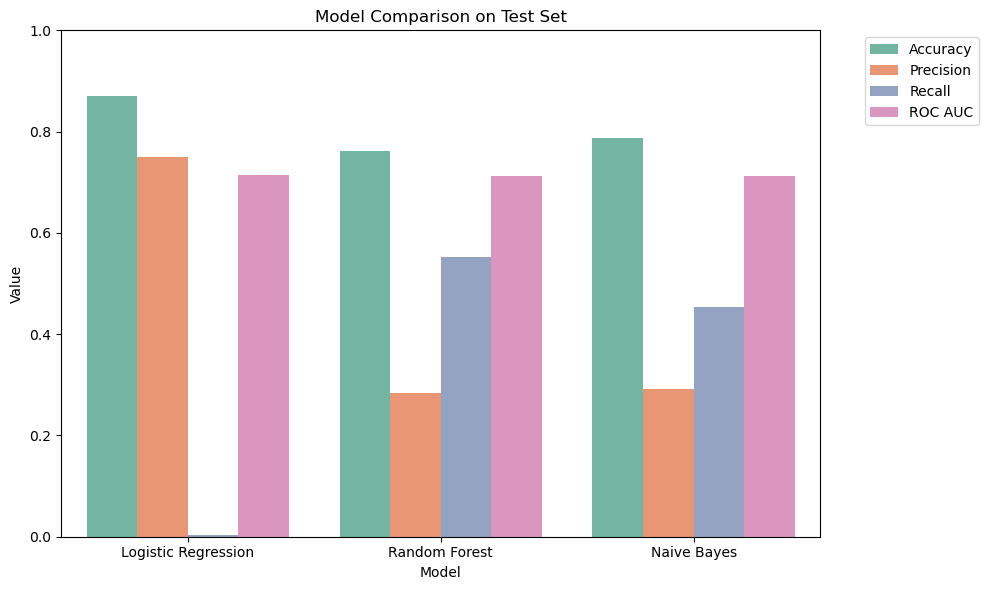

In [54]:

# ================================================
# 7. VISUALIZATIONS FOR COMPARISON
# ================================================

# --- (A) Confusion Matrices ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test_scaled)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues')
    ax.title.set_text(f'{name} - Confusion Matrix')
plt.tight_layout()
plt.show()

# --- (B) ROC Curves ---
plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    RocCurveDisplay.from_predictions(y_test, y_pred_proba, name=name, ax=plt.gca())
plt.title("ROC Curves Comparison")
plt.legend()
plt.show()

# --- (C) Bar Plot of Accuracy, Precision, Recall, and ROC AUC ---
df_results = pd.DataFrame(results)
melted = df_results.melt(id_vars="Model", var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x="Model", y="Value", hue="Metric", palette="Set2")
plt.title("Model Comparison on Test Set")
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Interpretation of Results**

**Logistic Regression**

- The model is correct 87% of the time overall (accuracy), which looks good at first glance. However, it barely catches any actual positives (recall = 0.0035). In other words, it’s almost never predicting “has capital costs” and thus misses nearly all true positives.  
- When it does predict a person has capital costs, it’s correct 75% of the time (precision = 0.75). But that happens so rarely that its recall is effectively near zero.  

**Random Forest**

- successfully captures over half of the true positives (recall ~ 55%). That’s a significant improvement since our goal is not to miss individuals who truly have capital costs.  
- Precision is 0.2840, meaning that when it flags someone as having capital costs, it’s correct about 28% of the time.  

**Naive Bayes**

- Naive Bayes falls between logistic regression and random forest in terms of accuracy (79%).  
- It has moderate recall (45%)—less than random forest but far better than logistic regression.It captures 45% of people who has capital costs. 
- Precision is similar to random forest (~29%), so it’s still producing a fair number of false positives.




**Comparison of Models**

Logistic regression doesn't have any advantages since it barely catches any person has capital costs (true positives)  


**Random forest**  

- **Advantage:**This model catches more actual positivies (persons with capital costs)
- **Disadvantage:**This model has moderate precision (~29%) hence it can still flag many false positives. 

**Naive Bayes**  

- **Advantage:**Very efficient to train even on large datasets. 
- **Disadvantage:**This model catches less actual positivies (persons with capital costs) when compared with Random forest. 

**Compare the model results using statistical comparison techniques**

In [56]:
import numpy as np
from scipy import stats
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_predict
import pandas as pd

# We need to perform paired statistical tests to compare the models on precision and recall
# We'll use 10-fold cross-validation to get paired scores for each model

# Create a function to get cross-validation precision and recall scores for all models
def get_cv_scores(models, X, y, cv):
    """
    Get cross-validation precision and recall scores for multiple models.
    
    Parameters:
    -----------
    models : dict
        Dictionary of models with model names as keys
    X : array-like
        Features
    y : array-like
        Target variable
    cv : cross-validation generator
        Cross-validation strategy
    
    Returns:
    --------
    dict
        Dictionary with model names as keys and dictionaries of metric scores as values
    """
    cv_scores = {}
    for name, model in models.items():
        # Use cross_val_predict to get predictions for each fold
        y_pred = cross_val_predict(model, X_train_scaled, y_train, cv=cv)
        
        # Calculate metrics
        precision = precision_score(y_train, y_pred)
        recall = recall_score(y_train, y_pred)
        
        cv_scores[name] = {
            'precision': precision,
            'recall': recall
        }
    return cv_scores

# Get cross-validation scores for each model using cross_val_predict for each fold
cv_scores_by_fold = {}
for name, model in models.items():
    precision_scores = []
    recall_scores = []
    
    # For each fold, calculate precision and recall
    for train_idx, test_idx in cv.split(X_train_scaled, y_train):
        X_fold_train, X_fold_test = X_train_scaled[train_idx], X_train_scaled[test_idx]
        y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
        
        # Fit and predict
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_test)
        
        # Calculate metrics
        precision_scores.append(precision_score(y_fold_test, y_fold_pred))
        recall_scores.append(recall_score(y_fold_test, y_fold_pred))
    
    cv_scores_by_fold[name] = {
        'precision': np.array(precision_scores),
        'recall': np.array(recall_scores)
    }

# Display mean and std for each metric
metrics = ['precision', 'recall']
print("Cross-validation performance statistics:\n")
for metric in metrics:
    print(f"\n{metric.capitalize()} scores:")
    for name in models.keys():
        scores = cv_scores_by_fold[name][metric]
        print(f"{name:<20}: Mean = {np.mean(scores):.4f}, Std = {np.std(scores):.4f}")

# Perform paired t-tests for each metric
model_names = list(models.keys())
num_models = len(model_names)
alpha = 0.05  # significance level

for metric in metrics:
    print(f"\n\nPaired t-test results for {metric}:\n")
    print(f"{'Model 1':<20} {'Model 2':<20} {'t-statistic':<12} {'p-value':<12} {'Significant?':<12}")
    print("-" * 80)
    
    for i in range(num_models):
        for j in range(i + 1, num_models):
            model1 = model_names[i]
            model2 = model_names[j]
            
            # Get the scores for the current metric
            scores1 = cv_scores_by_fold[model1][metric]
            scores2 = cv_scores_by_fold[model2][metric]
            
            # Paired t-test
            t_stat, p_val = stats.ttest_rel(scores1, scores2)
            
            # Determine if the difference is statistically significant
            significant = "Yes" if p_val < alpha else "No"
            
            # Print results
            print(f"{model1:<20} {model2:<20} {t_stat:>10.4f}  {p_val:>10.4f}  {significant:>10}")


/Users/karthikradhakrishnan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karthikradhakrishnan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karthikradhakrishnan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karthikradhakrishnan/opt/anaco

Cross-validation performance statistics:


Precision scores:
Logistic Regression : Mean = 0.3500, Std = 0.3905
Random Forest       : Mean = 0.3130, Std = 0.0132
Naive Bayes         : Mean = 0.3177, Std = 0.0151

Recall scores:
Logistic Regression : Mean = 0.0018, Std = 0.0020
Random Forest       : Mean = 0.5646, Std = 0.0147
Naive Bayes         : Mean = 0.4426, Std = 0.0184


Paired t-test results for precision:

Model 1              Model 2              t-statistic  p-value      Significant?
--------------------------------------------------------------------------------
Logistic Regression  Random Forest            0.2793      0.7863          No
Logistic Regression  Naive Bayes              0.2438      0.8129          No
Random Forest        Naive Bayes             -1.7753      0.1096          No


Paired t-test results for recall:

Model 1              Model 2              t-statistic  p-value      Significant?
------------------------------------------------------------------------

**Analysis of Important features**

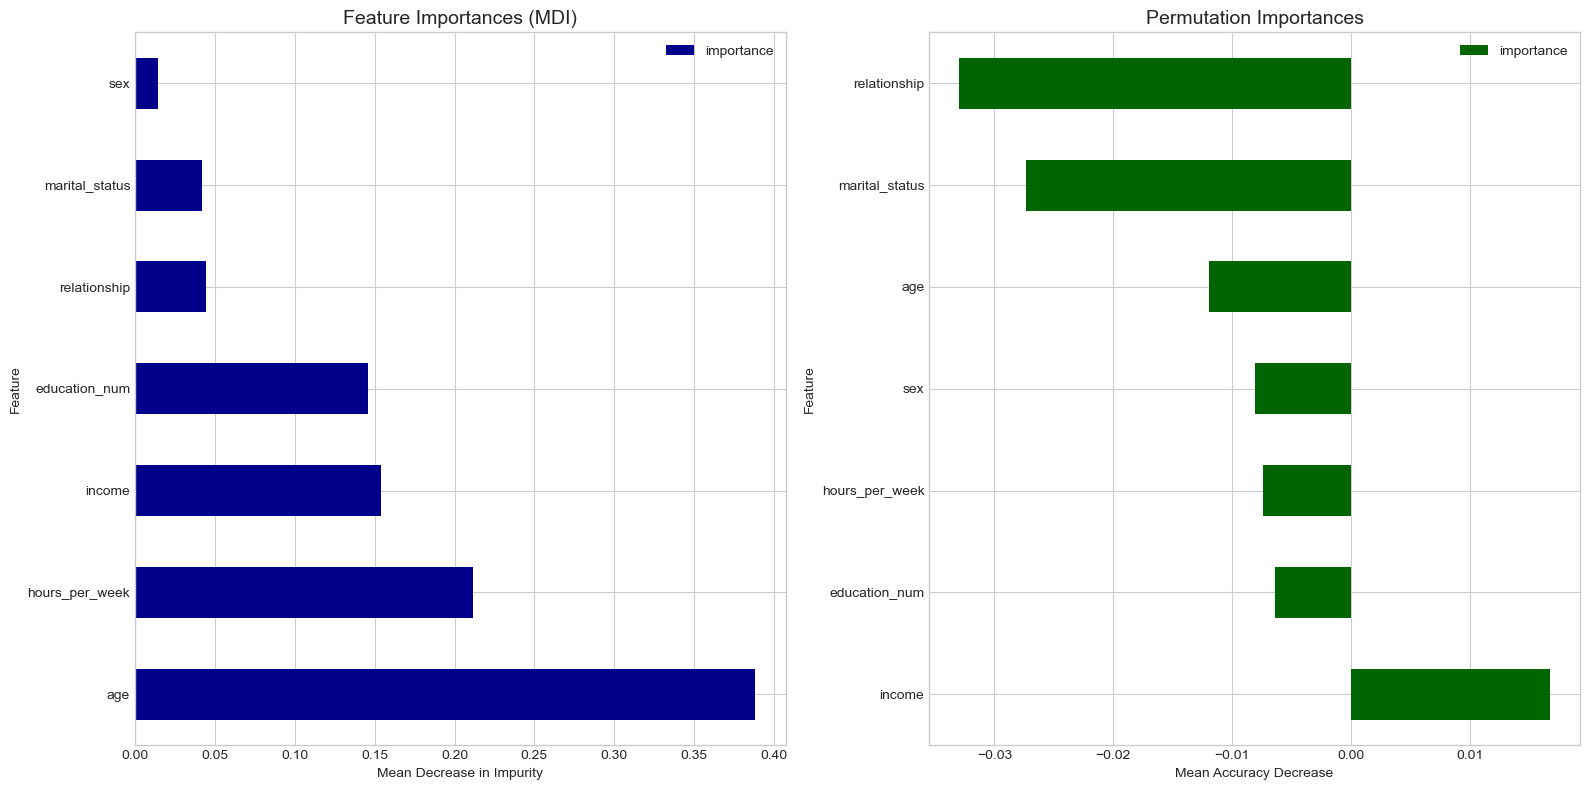

Top 3 features by Mean Decrease in Impurity (MDI):
          feature  importance
0             age    0.387963
5  hours_per_week    0.211834
6          income    0.153831

Top 3 features by Permutation Importance:
          feature  importance
6          income    0.016797
1   education_num   -0.006418
5  hours_per_week   -0.007370

Feature correlations with target (has_capital):
         feature  correlation
6         income     0.305720
1  education_num     0.142782
0            age     0.130390


In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# 1. Feature Importance using Random Forest (Mean Decrease in Impurity)
rf_importance = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf_importance.fit(X_train_scaled, y_train)

# Get feature importances
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_importance.feature_importances_
}).sort_values('importance', ascending=False)

# 2. Permutation Importance (more reliable than MDI)
# This measures how much model performance decreases when a feature is randomly shuffled
perm_importance = permutation_importance(
    rf_importance, X_test_scaled, y_test, 
    n_repeats=10, random_state=42, n_jobs=-1
)

# Create a DataFrame for permutation importances
perm_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=False)

# 3. Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot Mean Decrease in Impurity (sorted)
feature_importances.plot.barh(x='feature', y='importance', ax=axes[0], color='darkblue')
axes[0].set_title('Feature Importances (MDI)', fontsize=14)
axes[0].set_xlabel('Mean Decrease in Impurity')
axes[0].set_ylabel('Feature')

# Plot Permutation Importance (sorted)
perm_importances.plot.barh(x='feature', y='importance', ax=axes[1], color='darkgreen')
axes[1].set_title('Permutation Importances', fontsize=14)
axes[1].set_xlabel('Mean Accuracy Decrease')
axes[1].set_ylabel('Feature')

plt.tight_layout()
plt.show()

# Print the top 3 features from both methods
print("Top 3 features by Mean Decrease in Impurity (MDI):")
print(feature_importances.head(3))

print("\nTop 3 features by Permutation Importance:")
print(perm_importances.head(3))

# Check correlations with target
correlations = pd.DataFrame({
    'feature': X.columns,
    'correlation': [abs(np.corrcoef(X[col], y)[0, 1]) for col in X.columns]
}).sort_values('correlation', ascending=False)

print("\nFeature correlations with target (has_capital):")
print(correlations.head(3))

**Deployment**

Organizations such as Banks or insurance companies will deploy this model to predict the customers with high capital for targeted marketing to sell their products such as personalized investment advice, Tax optimization stratagies , Risk management and Insurance products etc. 

Businesses can use the data of their consumers to collect the relevant model. Model's value can be measured by monitoring the number of successful sales conversions i.e number of new consumers onboarded based on model's prediction.  Data need to be updated at least every year to get the latest data such as changing income level, marital status changes , new job etc...